# <font color="orange"> Logistic Regression Project: Diabetes Prediction </font>

In [3]:
# import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
import itertools

# for solve problem of show plotly plots
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

from warnings import filterwarnings
filterwarnings('ignore')
plt.style.use('_mpl-gallery')

In [5]:
from sklearn.model_selection import train_test_split , GridSearchCV, KFold, cross_val_score, RepeatedStratifiedKFold
from sklearn.preprocessing import MinMaxScaler , StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn import metrics


In [7]:
# import diabetes dataset
data = pd.read_csv("diabetes.csv")
data

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


# <font color='orange'> 1. Dataset Overview </font>

In [8]:
df = pd.DataFrame(data)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


# <font color='orange'> 2. Cleaning and Preparing Data </font>

In [9]:
df.isnull().sum()
# df.isna().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

We have 9 columns, none of which seem to have missing values

In [10]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.0,3.845052,3.369578,0.000,1.00000,3.0000,6.00000,17.00
Glucose,768.0,120.894531,31.972618,0.000,99.00000,117.0000,140.25000,199.00
BloodPressure,768.0,69.105469,19.355807,0.000,62.00000,72.0000,80.00000,122.00
SkinThickness,768.0,20.536458,15.952218,0.000,0.00000,23.0000,32.00000,99.00
Insulin,768.0,79.799479,115.244002,0.000,0.00000,30.5000,127.25000,846.00
BMI,768.0,31.992578,7.884160,0.000,27.30000,32.0000,36.60000,67.10
DiabetesPedigreeFunction,768.0,0.471876,0.331329,0.078,0.24375,0.3725,0.62625,2.42
Age,768.0,33.240885,11.760232,21.000,24.00000,29.0000,41.00000,81.00
Outcome,768.0,0.348958,0.476951,0.000,0.00000,0.0000,1.00000,1.00


In [11]:
df.duplicated().sum()

0

Ok There is no duplicate data

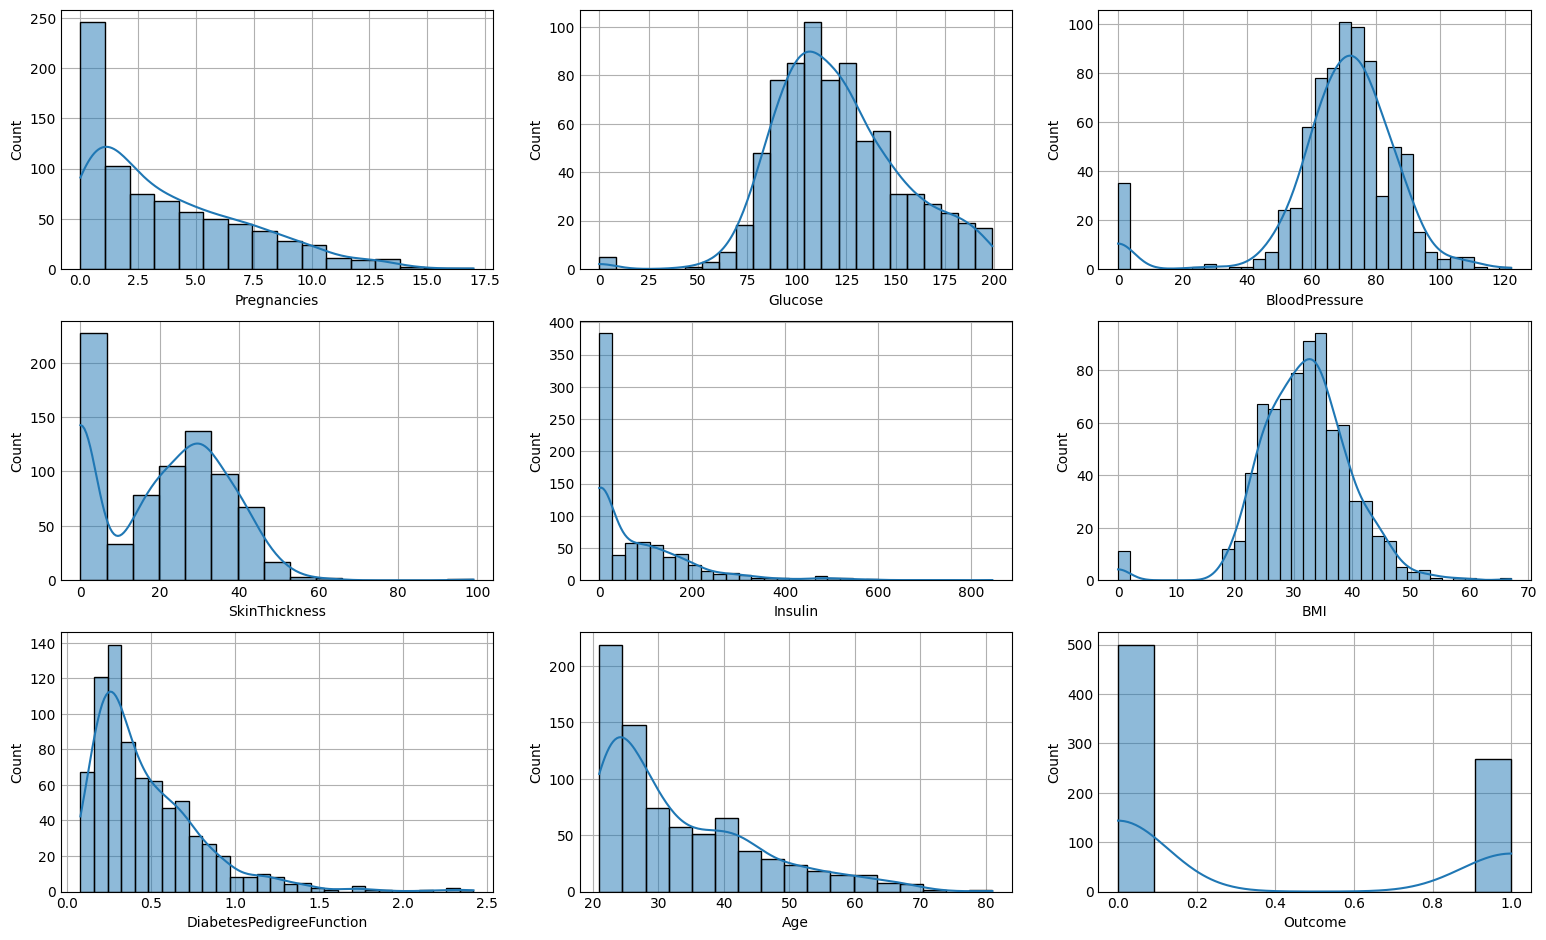

In [12]:
# Now draw plots and check the noisy data:
# first we check the data distribution:
%matplotlib inline
fig, ax = plt.subplots(3,3,figsize=(15,9))
for i, col in enumerate(df):
    sns.histplot(df[col], kde=True, ax=ax[i//3, i%3])
    # plt.title(f"{col} ditribution", fontsize=14, fontweight='bold', c='r')
plt.show()

In [13]:
df1 = df.copy()
zero_col = ['Glucose','Insulin','SkinThickness','BloodPressure','BMI']
df1[zero_col] = df1[zero_col].replace(0, np.nan)

In [14]:
df1.isna().sum()

Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64

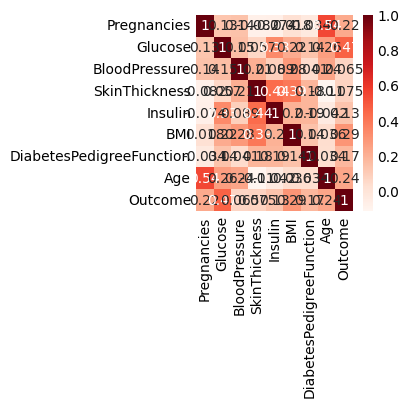

In [15]:
%matplotlib inline
sns.heatmap(data.corr(), annot=True, cmap='Reds')
plt.show()

- I don't have expertise or science in medicine, but I think that glucose, insulin, skin thickness, blood pressure, and BMI cannot have a zero value, and since I don't have access to the owner of the data to research this data, so I have to fill or drop these data
- The features do not have much correlation with each other and therefore they cannot be filled according to each other. Also, since the number of false zero data is high, removing them is not a good solution so I fill them according to distribution data
- Mean is most useful when the original data is not skewed, while the median is more robust, not sensitive to outliers, and thus used when data is skewed.
- As can be seen in the data distribution charts, insulin, glucose and skin thickness are deviated to the right and left, so we fill them with Madin. On the other hand, BMI and blood pressure have a normal distribution and we use the average to fill them 

In [16]:
for col in ['Glucose','Insulin','SkinThickness']:
    median_col = np.median(df1[df1[col].notna()][col])
    df1[col] = df1[col].fillna(median_col)
for col in ['BMI','BloodPressure']:
    mean_col = np.mean(df1[df1[col].notna()][col])
    df1[col] = df1[col].fillna(mean_col)

In [17]:
df1.isna().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [18]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    float64
 2   BloodPressure             768 non-null    float64
 3   SkinThickness             768 non-null    float64
 4   Insulin                   768 non-null    float64
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(6), int64(3)
memory usage: 54.1 KB


# <font color="orange"> 3.Exploratory Data Analysis (EDA) </font>

### <font color="orange"> 3.1.Univariate Analysis: </font>

In [19]:
df1.describe().T

,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.0,3.845052,3.369578,0.000,1.00000,3.000000,6.00000,17.00
Glucose,768.0,121.656250,30.438286,44.000,99.75000,117.000000,140.25000,199.00
BloodPressure,768.0,72.405184,12.096346,24.000,64.00000,72.202592,80.00000,122.00
SkinThickness,768.0,29.108073,8.791221,7.000,25.00000,29.000000,32.00000,99.00
Insulin,768.0,140.671875,86.383060,14.000,121.50000,125.000000,127.25000,846.00
BMI,768.0,32.457464,6.875151,18.200,27.50000,32.400000,36.60000,67.10
DiabetesPedigreeFunction,768.0,0.471876,0.331329,0.078,0.24375,0.372500,0.62625,2.42
Age,768.0,33.240885,11.760232,21.000,24.00000,29.000000,41.00000,81.00
Outcome,768.0,0.348958,0.476951,0.000,0.00000,0.000000,1.00000,1.00


- According to above table, Most people in this dataset do not have diabetes.

#### <font color="orange"> 3.2.Numeric - Numeric Bivariate Analysis: </font>

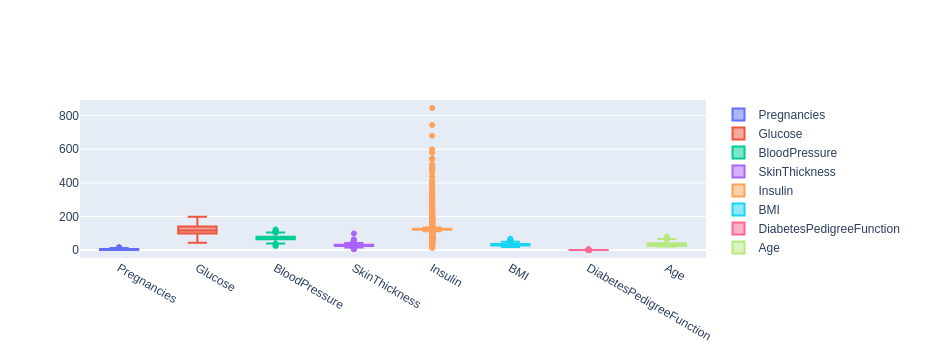

In [21]:
fig = go.Figure()
my_cols = ['Pregnancies','Glucose','BloodPressure','SkinThickness',
           'Insulin','BMI','DiabetesPedigreeFunction','Age']
for col in my_cols:
    fig.add_trace(go.Box(y=df1[col], name=f'{col}'))
fig.show()

# <font color='orange'> 4.Do a logistic regression for this dataset </font>